### 이벤트 아티스트 발굴 모델링
- 아티스트별로 최적화된 이벤트를 기획하기 위한 클러스터링 분석 및 모델 작업

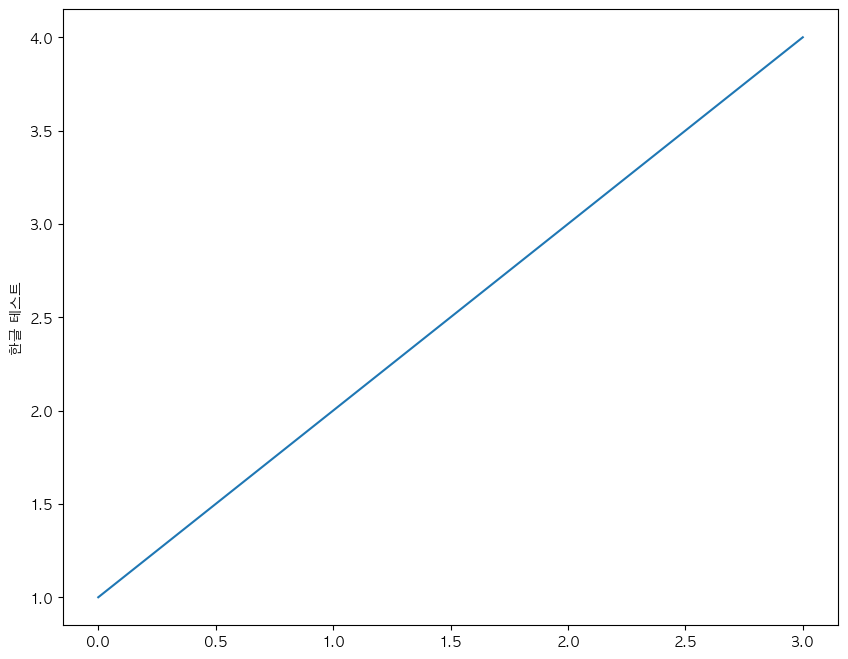

In [44]:
## import library
import trino
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


plt.rcParams['figure.figsize'] = [10, 8]

conn = trino.dbapi.connect(
    host='kakaoent-presto-adhoc.kakaoent.io',
    port=8443,
    user='samuel-ch',
    catalog='hadoop_kent',
    schema='default',                          # 사용할 Database 지정
    http_scheme='https',
    auth=trino.auth.BasicAuthentication("samuel-ch", "melon!Q2w3e"),  # 카카오 LDAP이 아닌 하둡 LDAP 입력
    http_headers={
        'X-Presto-User': 'samuel-ch',
        'X-Presto-Time-Zone': 'Asia/Seoul'
    },
)
cur = conn.cursor()

# Set CSS properties for th elements in dataframe
th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', '#6d6d6d'),
  ('background-color', '#f7f7f9')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '11px')
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]

cm = sns.light_palette("green", as_cmap=True)

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# AppleGothic 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'

# 테스트 플롯
plt.plot([1, 2, 3, 4])
plt.ylabel('한글 테스트')
plt.show()

### 이벤트 아티스트 성별,연령대 분포에 따른 인사이트
- 22년도 데뷔후 주요 아티스트들의 팬덤 분포(연령대,성별)
- 남자 순위 여자순위.
- 남성 비중, 여성비중 ~ 팬덤 사용자 증감 상관계수

In [45]:
# 남성,여성비중 증감과 팬덤 사용자 증감 상관성 분석 
fandom_user_gndr_query = '''
    select t1.artist_id
         , t2.artist_name_web_list
         , t2.debut_day
         , t1.dt
         , t1.user_cnt 
         , t1.male_user_cnt
         , t1.female_user_cnt
         , cast(t1.female_user_cnt as double)/t1.user_cnt*100 as female_user_ratio
         , t1.age_102030_user_cnt
         , cast(t1.age_102030_user_cnt as double)/t1.user_cnt*100 as age_102030_user_ratio
    from(
        select artist_id             
             , date(date_parse(log_date,'%Y%m%d')) as dt
             , count(distinct A.member_key) as user_cnt
             , count(distinct if(MEMBER_GNDR = 1,A.member_key)) as male_user_cnt
             , count(distinct if(MEMBER_GNDR = 2,A.member_key)) as female_user_cnt
             , count(distinct if(AGE_ENT_PRT_CD in (1,23,4,5,6),A.member_key)) as age_102030_user_cnt
        from HADOOP_KENT.MELON_MA_PROD_PRODUCTION.A_USER_ARTIST_FANDOM_TRGT_DAY  A
        left join(
            select MEMBER_KEY
                 , MEMBER_GNDR
                 , AGE_ENT_PRT_CD
            from HADOOP_KENT.MELON_MA_TMK_PRODUCTION.A_USER_PROFILE_DAY
            where log_date = '20250511'
            GROUP BY 1,2,3
        ) B on A.member_key = B.member_key
        where log_date between '20240101' and '20250511'
        and (CONTAINS(FANDOM_TYPE,'A')=true OR CONTAINS(FANDOM_TYPE,'B')=true OR CONTAINS(FANDOM_TYPE,'C')=true)
        and artist_id in (3207401,3466604,3458776,3478478,3114174,3180539,3064111,3092950,3070786,3610529,3743525,3457231,3156910,2399724)
        and B.member_key is not null
        group by 1,2
    ) t1    
    left join hadoop_kent.melon_ods_meta_production.pb_artist_dtl_tb_ro t2 on t1.artist_id = t2.artist_id
    order by 1,4
'''

cur.execute(fandom_user_gndr_query)

results = cur.fetchall()
colnames = [part[0] for part in cur.description]

fandom_user_gndr = pd.DataFrame(results, columns=colnames)

cur.cancel()
conn.close()
fandom_user_gndr.head()

,artist_id,artist_name_web_list,debut_day,dt,user_cnt,male_user_cnt,female_user_cnt,female_user_ratio,age_102030_user_cnt,age_102030_user_ratio
0,2399724,YENA (최예나),20220117,2024-01-01,2894,1606,1288,44.505874,1101,38.044229
1,2399724,YENA (최예나),20220117,2024-01-02,2893,1606,1287,44.486692,1101,38.057380
2,2399724,YENA (최예나),20220117,2024-01-03,2894,1607,1287,44.471320,1101,38.044229
3,2399724,YENA (최예나),20220117,2024-01-04,2893,1607,1286,44.452126,1101,38.057380
4,2399724,YENA (최예나),20220117,2024-01-05,2893,1607,1286,44.452126,1101,38.057380


    artist_name_web_list  male_corr  female_corr
0            BOYNEXTDOOR   0.934122     0.999043
1            FIFTY FIFTY   0.988347     0.981014
2           H1-KEY (하이키)   0.986073     0.989127
3     LE SSERAFIM (르세라핌)   0.990987     0.994317
4                  NMIXX   0.984084     0.973457
5               NewJeans   0.964663     0.994484
6                  PLAVE   0.948884     0.999501
7                   QWER   0.982112     0.860525
8                  RIIZE   0.936901     0.999255
9             YENA (최예나)   0.999135     0.998519
10  ZEROBASEONE (제로베이스원)   0.808898     0.953284
11                아이리 칸나   0.987252     0.795778
12            아일릿(ILLIT)   0.983038     0.996509
13                   황영웅   0.828244     0.997023


/var/folders/qw/6lks7c5d14scf7qtctm8m6jh0000gn/T/ipykernel_50584/86026136.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlation_results = correlation_data.groupby('artist_name_web_list').apply(


<Figure size 1200x800 with 0 Axes>

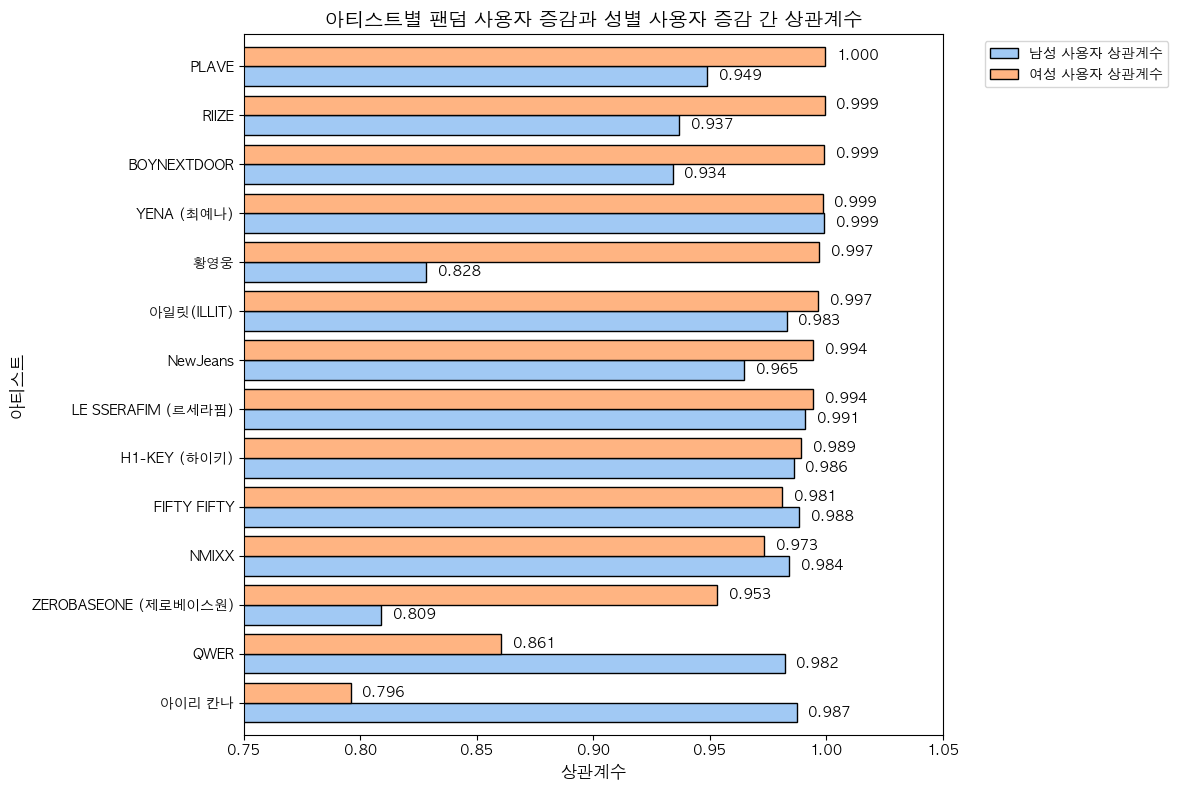

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 로드 (fandom_user_gndr 데이터프레임이 이미 준비되어 있다고 가정)
# fandom_user_gndr = pd.DataFrame(...) 

# 남성 사용자 증감과 여성 사용자 증감을 계산
fandom_user_gndr['male_user_diff'] = fandom_user_gndr.groupby('artist_name_web_list')['male_user_cnt'].diff()
fandom_user_gndr['female_user_diff'] = fandom_user_gndr.groupby('artist_name_web_list')['female_user_cnt'].diff()
fandom_user_gndr['user_diff'] = fandom_user_gndr.groupby('artist_name_web_list')['user_cnt'].diff()

# 상관성 분석을 위한 데이터 필터링 (NaN 제거)
correlation_data = fandom_user_gndr.dropna(subset=['male_user_diff', 'female_user_diff', 'user_diff'])

# 아티스트별 상관계수 계산
correlation_results = correlation_data.groupby('artist_name_web_list').apply(
    lambda group: pd.Series({
        'male_corr': group['user_diff'].corr(group['male_user_diff']),
        'female_corr': group['user_diff'].corr(group['female_user_diff'])
    })
).reset_index()

# 결과 출력
print(correlation_results)

# 여성 사용자 상관계수 기준으로 내림차순 정렬
correlation_results_sorted = correlation_results.sort_values(by='female_corr', ascending=True)

# 시각화: 아티스트별 상관계수 비교 (수평 막대 그래프)
plt.figure(figsize=(12, 8))
ax = correlation_results_sorted.set_index('artist_name_web_list')[['male_corr', 'female_corr']].plot(
    kind='barh', figsize=(12, 8), color=sns.color_palette("pastel", 2), edgecolor='black', width=0.8
)

plt.title('아티스트별 팬덤 사용자 증감과 성별 사용자 증감 간 상관계수', fontsize=14)
plt.xlabel('상관계수', fontsize=12)
plt.ylabel('아티스트', fontsize=12)

# x축 범위를 0.75~1.0으로 설정
plt.xlim(0.75, 1.05)

# 각 막대 끝에 상관계수 값 추가
for bars, corr_label in zip(ax.containers, ['male_corr', 'female_corr']):
    for bar in bars:
        width = bar.get_width()
        plt.text(
            width + 0.005,  # 막대 끝에서 약간 오른쪽으로 위치
            bar.get_y() + bar.get_height() / 2,  # 막대의 중앙에 위치
            f'{width:.3f}',  # 소수점 두 자리까지 표시
            ha='left', va='center', fontsize=10, color='black'
        )

# 범례를 그래프 바깥으로 이동
plt.legend(['남성 사용자 상관계수', '여성 사용자 상관계수'], fontsize=10, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

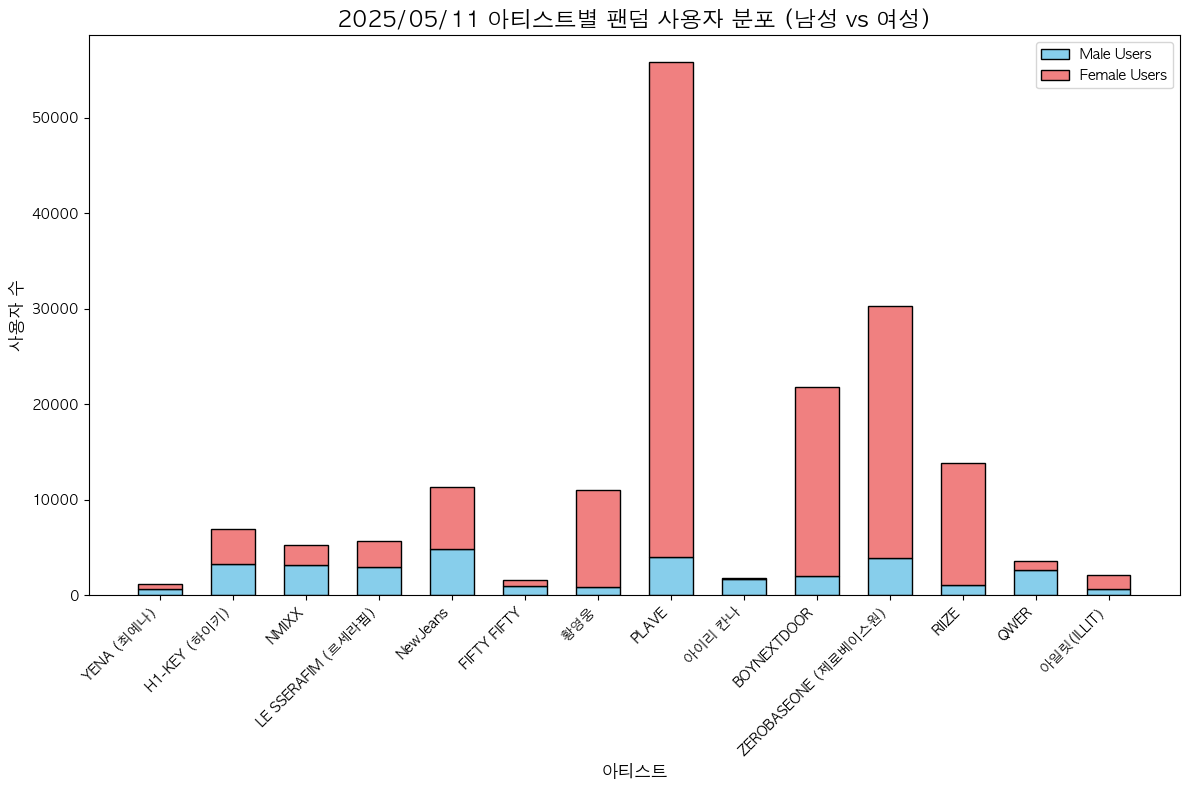

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# 'dt' 컬럼의 데이터 타입 확인 및 변환
if fandom_user_gndr['dt'].dtype == 'object':
    fandom_user_gndr['dt'] = pd.to_datetime(fandom_user_gndr['dt'], errors='coerce')

# 2025/05/11 데이터 필터링
latest_date = '2025-05-11'
filtered_data = fandom_user_gndr[fandom_user_gndr['dt'] == latest_date].copy()

# 스택형 바 플롯 생성
plt.figure(figsize=(12, 8))
bar_width = 0.6

# 남성 사용자와 여성 사용자 데이터
male_users = filtered_data['male_user_cnt']
female_users = filtered_data['female_user_cnt']
artists = filtered_data['artist_name_web_list']

# 스택형 바 플롯
plt.bar(artists, male_users, label='Male Users', color='skyblue', edgecolor='black', width=bar_width)
plt.bar(artists, female_users, bottom=male_users, label='Female Users', color='lightcoral', edgecolor='black', width=bar_width)

# 그래프 꾸미기
plt.title('2025/05/11 아티스트별 팬덤 사용자 분포 (남성 vs 여성)', fontsize=16)
plt.xlabel('아티스트', fontsize=12)
plt.ylabel('사용자 수', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(fontsize=10)
plt.tight_layout()

# 그래프 출력
plt.show()

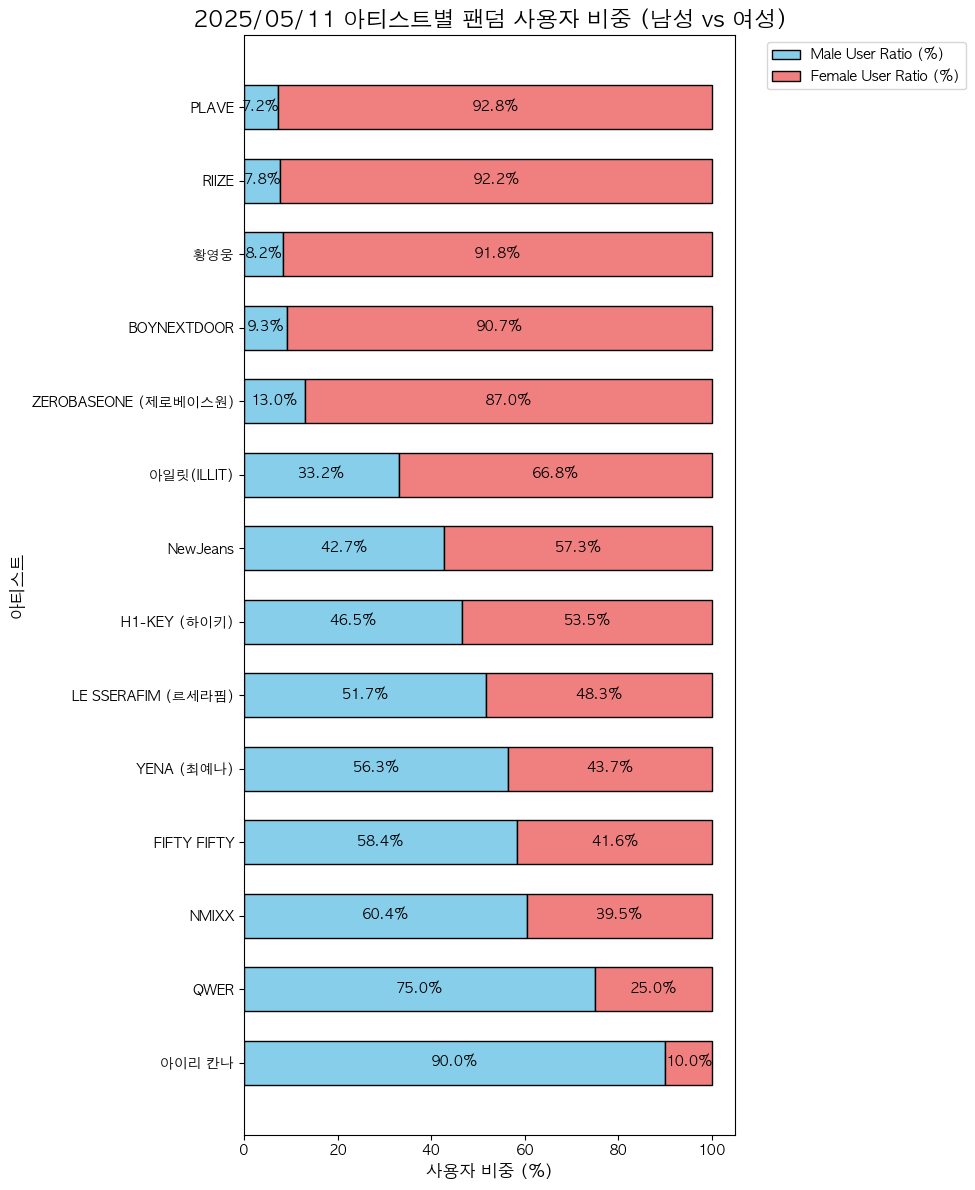

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# 'dt' 컬럼의 데이터 타입 확인 및 변환
if fandom_user_gndr['dt'].dtype == 'object':
    fandom_user_gndr['dt'] = pd.to_datetime(fandom_user_gndr['dt'], errors='coerce')

# 2025/05/11 데이터 필터링
latest_date = '2025-05-11'
filtered_data = fandom_user_gndr[fandom_user_gndr['dt'] == latest_date].copy()

# 여성 사용자 비중과 남성 사용자 비중 계산
#filtered_data['female_user_ratio'] = (filtered_data['female_user_cnt'] / filtered_data['user_cnt']) * 100
filtered_data['male_user_ratio'] = (filtered_data['male_user_cnt'] / filtered_data['user_cnt']) * 100

# 여성 사용자 상관계수 기준으로 내림차순 정렬
filtered_data = filtered_data.sort_values(by='female_user_ratio', ascending=True)

# 스택형 바 플롯 생성 (x축과 y축 전환)
plt.figure(figsize=(10, 12))
bar_width = 0.6

# 남성 사용자 비중과 여성 사용자 비중 데이터
male_ratios = filtered_data['male_user_ratio']
female_ratios = filtered_data['female_user_ratio']
artists = filtered_data['artist_name_web_list']

# 스택형 바 플롯 (x축과 y축 전환)
plt.barh(artists, male_ratios, label='Male User Ratio (%)', color='skyblue', edgecolor='black', height=bar_width)
plt.barh(artists, female_ratios, left=male_ratios, label='Female User Ratio (%)', color='lightcoral', edgecolor='black', height=bar_width)

# 영역별 비율 표시
for i, (male, female) in enumerate(zip(male_ratios, female_ratios)):
    plt.text(male / 2, i, f'{male:.1f}%', ha='center', va='center', fontsize=10, color='black')  # 남성 비율
    plt.text(male + female / 2, i, f'{female:.1f}%', ha='center', va='center', fontsize=10, color='black')  # 여성 비율

# 그래프 꾸미기
plt.title('2025/05/11 아티스트별 팬덤 사용자 비중 (남성 vs 여성)', fontsize=16)
plt.xlabel('사용자 비중 (%)', fontsize=12)
plt.ylabel('아티스트', fontsize=12)
plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1.05, 1))  # 레전드를 그래프 바깥으로 이동
plt.tight_layout()

# 그래프 출력
plt.show()

datetime64[ns]


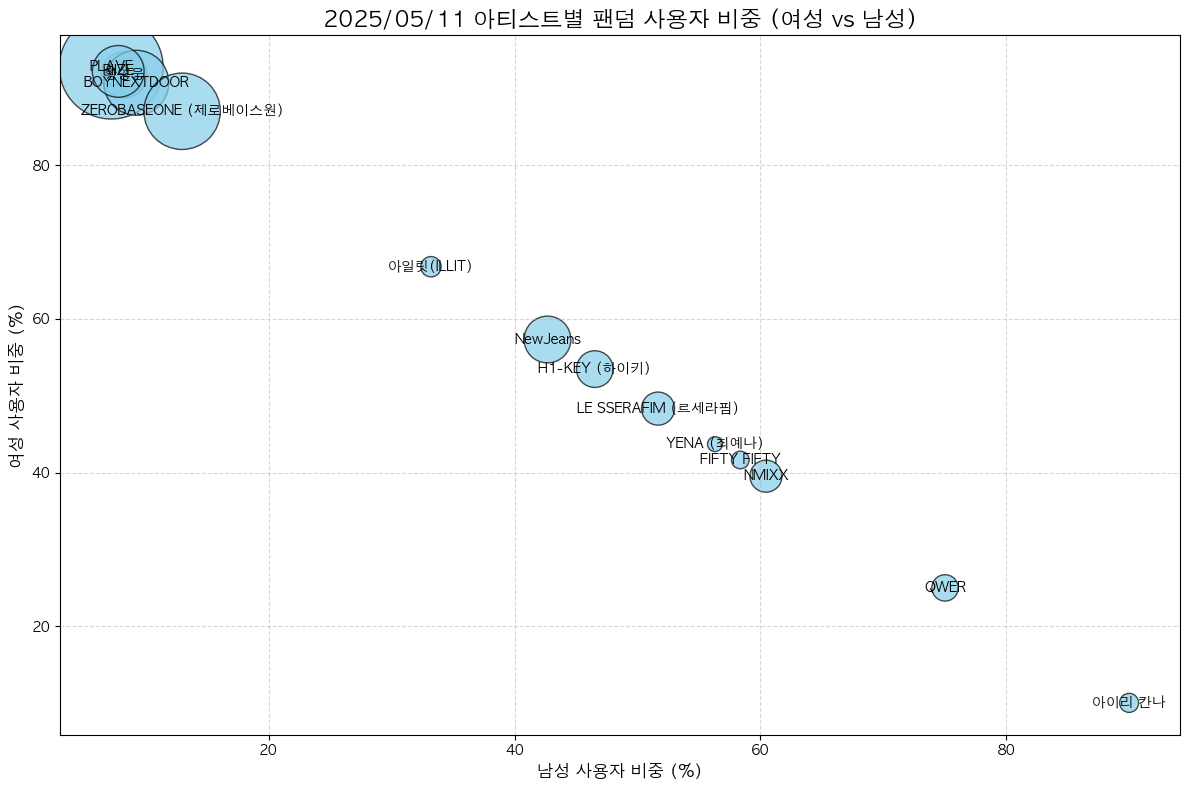

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# 'dt' 컬럼의 데이터 타입 확인
print(fandom_user_gndr['dt'].dtype)

# 'dt' 컬럼이 문자열이라면 datetime으로 변환
if fandom_user_gndr['dt'].dtype == 'object':
    fandom_user_gndr['dt'] = pd.to_datetime(fandom_user_gndr['dt'], errors='coerce')

# 2025/05/11 데이터 필터링
latest_date = '2025-05-11'
filtered_data = fandom_user_gndr[fandom_user_gndr['dt'] == latest_date].copy()

# 여성 사용자 비중과 남성 사용자 비중 계산
filtered_data['female_user_ratio'] = (filtered_data['female_user_cnt'] / filtered_data['user_cnt']) * 100
filtered_data['male_user_ratio'] = (filtered_data['male_user_cnt'] / filtered_data['user_cnt']) * 100

# Scatter plot 생성
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    filtered_data['male_user_ratio'], 
    filtered_data['female_user_ratio'],     
    s=filtered_data['user_cnt'] / 10,  # 팬덤 사용자 수에 비례한 점 크기
    alpha=0.7, 
    c='skyblue', 
    edgecolor='black'
)

# 각 점에 아티스트 이름 추가
for i, row in filtered_data.iterrows():
    plt.text(
        row['male_user_ratio'], 
        row['female_user_ratio'],         
        row['artist_name_web_list'], 
        fontsize=10, 
        ha='center', 
        va='center'
    )

# 그래프 꾸미기
plt.title('2025/05/11 아티스트별 팬덤 사용자 비중 (여성 vs 남성)', fontsize=16)
plt.xlabel('남성 사용자 비중 (%)', fontsize=12)
plt.ylabel('여성 사용자 비중 (%)', fontsize=12)
plt.grid(alpha=0.5, linestyle='--')
plt.tight_layout()

# 그래프 출력
plt.show()

datetime64[ns]


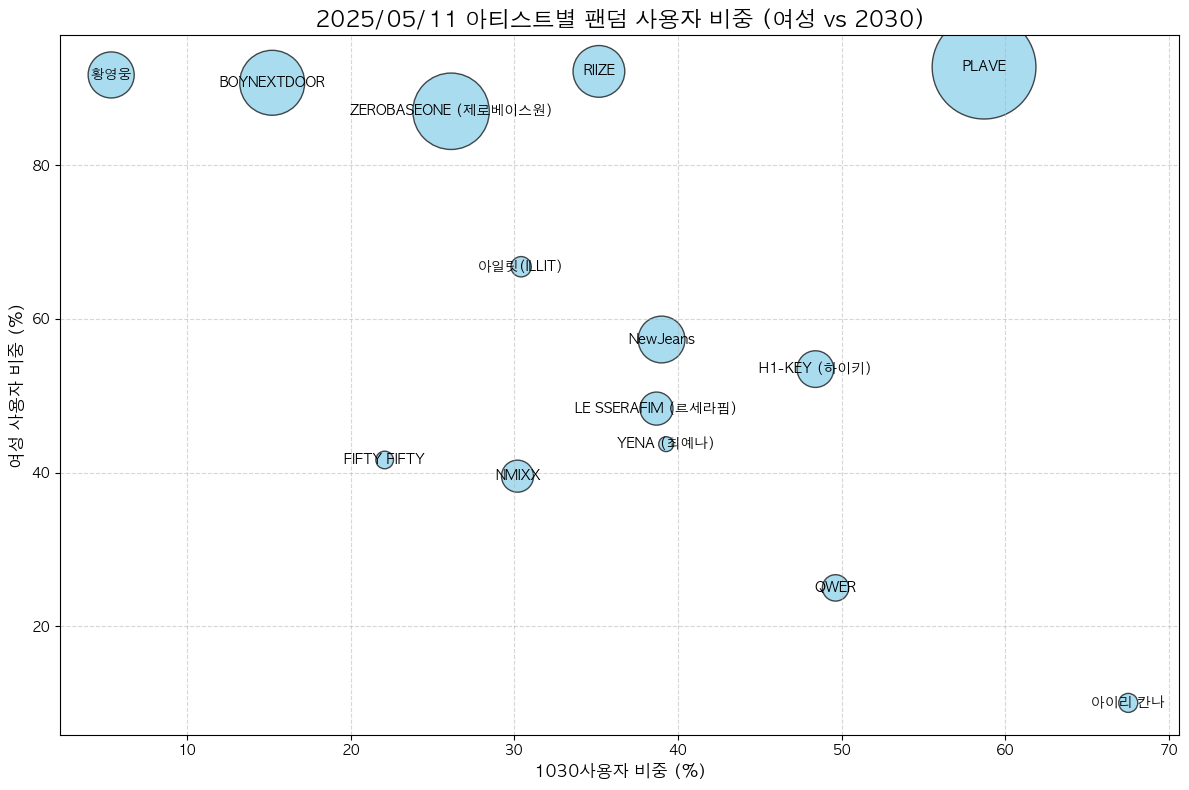

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# 'dt' 컬럼의 데이터 타입 확인
print(fandom_user_gndr['dt'].dtype)

# 'dt' 컬럼이 문자열이라면 datetime으로 변환
if fandom_user_gndr['dt'].dtype == 'object':
    fandom_user_gndr['dt'] = pd.to_datetime(fandom_user_gndr['dt'], errors='coerce')

# 2025/05/11 데이터 필터링
latest_date = '2025-05-11'
filtered_data = fandom_user_gndr[fandom_user_gndr['dt'] == latest_date].copy()


# Scatter plot 생성
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    filtered_data['age_102030_user_ratio'], 
    filtered_data['female_user_ratio'],     
    s=filtered_data['user_cnt'] / 10,  # 팬덤 사용자 수에 비례한 점 크기
    alpha=0.7, 
    c='skyblue', 
    edgecolor='black'
)

# 각 점에 아티스트 이름 추가
for i, row in filtered_data.iterrows():
    plt.text(
        row['age_102030_user_ratio'], 
        row['female_user_ratio'],         
        row['artist_name_web_list'], 
        fontsize=10, 
        ha='center', 
        va='center'
    )

# 그래프 꾸미기
plt.title('2025/05/11 아티스트별 팬덤 사용자 비중 (여성 vs 2030)', fontsize=16)
plt.xlabel('1030사용자 비중 (%)', fontsize=12)
plt.ylabel('여성 사용자 비중 (%)', fontsize=12)
plt.grid(alpha=0.5, linestyle='--')
plt.tight_layout()

# 그래프 출력
plt.show()

### 스트리밍건수에 따른 팬덤 아티스트 분류
- 신규 유입 스트리밍 사용자가 높은 아티스트는?
- 신규유입 스트리밍 사용자 최근 30일이내 해당 아티스트 스트리밍 & 최근 180일이내 스트리밍 이력이 없는 사용자
- 이벤트 참여도를 위한 간접적인 지표를 위하여 앨범 발매 전후로 스트리밍량 증감(앨범 발매 후 7일간 스트리밍 / 직전 7일 스트리밍건수)
- 발매 일주일 후 스트리밍 감소: 단발성 사용자 비중

In [51]:
# 앨범 발매 전후로 스트리밍 사용량 증감 확인 >  if 스트리밍 사용자 및 사용량 증감이 크다면 이벤트 참여도도 증가할 것
fandom_artist_st_incre_query = '''
with artist_df as(    
     select cast(artist_id as bigint) as artist_id
         , artist_name
         , fandom_user_cnt
         , male_user_cnt
         , female_user_cnt
         , female_user_ratio
         , age_2030_user_cnt
         , age_2030_user_ratio
         , album_id
         , album_name_web_list as album_name
         , issue_date
         , date(date_parse(issue_date,'%Y%m%d')) as peak_st_strt_date
         , date(date_parse(issue_date,'%Y%m%d') + interval '6' day) as peak_st_end_date
         , date(date_parse(issue_date,'%Y%m%d') - interval '7' day) as pre_st_strt_date
         , date(date_parse(issue_date,'%Y%m%d') - interval '1' day) as pre_st_end_date
         , date(date_parse(issue_date,'%Y%m%d') + interval '7' day) as drop_off_st_strt_date 
         , date(date_parse(issue_date,'%Y%m%d') + interval '14' day) as drop_off_st_end_date 
    from(     
    select A.rep_artist_id_basket as artist_id
         , C.artist_name_web_list as artist_name
         , A.album_id
         , A.album_name_web_list
         , A.issue_date
         , B.fandom_user_cnt
         , B.male_user_cnt
         , B.female_user_cnt
         , B.female_user_ratio
         , B.age_2030_user_cnt
         , B.age_2030_user_ratio
         , rank() over(partition by A.rep_artist_id_basket order by A.issue_date desc) as rnk
    from hadoop_kent.melon_ods_meta_production.pb_album_dtl_tb_ro A
    join (
        select t1.artist_id
             , t1.fandom_user_cnt
             , t1.male_user_cnt
             , t1.female_user_cnt
             , cast(t1.female_user_cnt as double)/t1.fandom_user_cnt*100 as female_user_ratio
             , t1.age_2030_user_cnt
             , cast(t1.age_2030_user_cnt as double)/t1.fandom_user_cnt*100 as age_2030_user_ratio
        from(
            select artist_id
                 , count(distinct A.member_key) as fandom_user_cnt
                 , count(distinct if(MEMBER_GNDR = 1,A.member_key)) as male_user_cnt
                 , count(distinct if(MEMBER_GNDR = 2,A.member_key)) as female_user_cnt
                 , count(distinct if(AGE_ENT_PRT_CD in (3,4,5,6),A.member_key)) as age_2030_user_cnt
            from HADOOP_KENT.MELON_MA_PROD_PRODUCTION.A_USER_ARTIST_FANDOM_TRGT_DAY A
            left join(
                select MEMBER_KEY
                     , MEMBER_GNDR
                     , AGE_ENT_PRT_CD
                from HADOOP_KENT.MELON_MA_TMK_PRODUCTION.A_USER_PROFILE_DAY
                where log_date = '20250511'
                GROUP BY 1,2,3
            ) B on A.member_key = B.member_key
            where log_date = '20250511'
            AND (CONTAINS(FANDOM_TYPE,'A')=true OR CONTAINS(FANDOM_TYPE,'B')=true OR CONTAINS(FANDOM_TYPE,'C')=true)
            group by 1
            having(count(distinct A.member_key) > 500)
        ) t1    
        left join hadoop_kent.melon_ods_meta_production.pb_artist_dtl_tb_ro t2 on t1.artist_id = t2.artist_id
        where (substr(t2.debut_day,1,4) > '2019' or t1.artist_id in (3478478,3466604))
    ) B on A.rep_artist_id_basket = cast(B.artist_id as varchar)
    left join hadoop_kent.melon_ods_meta_production.pb_artist_dtl_tb_ro C on A.rep_artist_id_basket = cast(C.artist_id as varchar)
    where substr(issue_date,1,8) < '20250501'
    --and A.rep_artist_id_basket in ('3207401','3466604','3458776','3478478','3114174','3180539','3064111','3092950','3070786','3610529','3743525','3457231','3156910','2399724')
    and A.album_type_cd in ('AE0006','AE0007', 'AE0009') /* 미니,정규앨범 기준 */
    --and A.album_type_cd in ('AE0004','AE0007','AE0006','AE0009','AE0010','AE0012') /* 라이브,싱글,EP,정규,OST,베스트 앨범유형 기준 */
    )
    where rnk = 1
    order by 3 desc
), date_df as(
    select melon_short_date_format(dt) as log_date
    from hadoop_kent.melon_ma_stat_production.d_base_dt A
    join artist_df B on A.dt between B.pre_st_strt_date and B.drop_off_st_end_date
    group by 1
)

select f1.artist_id
     , f1.artist_name
     , f1.fandom_user_cnt
     , f1.male_user_cnt
     , f1.female_user_cnt
     , f1.female_user_ratio
     , f1.age_2030_user_cnt
     , f1.age_2030_user_ratio
     , f1.album_name
     , f1.issue_date
     , f1.pre_st_cnt
     , f2.peak_st_cnt
     , f3.drop_off_st_cnt     
     , cast(f2.peak_st_cnt as double)/cast(f1.pre_st_cnt as double) as peak_st_incre
     , cast(f2.peak_st_cnt - f1.pre_st_cnt as double)/cast(f1.pre_st_cnt as double)*100 as peak_st_incre_ratio
     , cast(f3.drop_off_st_cnt as double)/cast(f2.peak_st_cnt as double) as drop_off_st_incre
     , cast(f3.drop_off_st_cnt - f2.peak_st_cnt as double)/cast(f2.peak_st_cnt as double)*100 as drop_off_st_incre_ratio
     , f1.pre_st_lv
     , f2.peak_st_lv
     , f3.drop_off_st_lv
     , cast(f2.peak_st_lv as double)/cast(f1.pre_st_lv as double) as peak_st_lv_incre
     , cast(f2.peak_st_lv - f1.pre_st_lv as double)/cast(f1.pre_st_lv as double)*100 as peak_st_lv_incre_ratio
     , cast(f3.drop_off_st_lv as double)/cast(f2.peak_st_lv as double) as drop_off_st_lv_incre
     , cast(f3.drop_off_st_lv - f2.peak_st_lv as double)/cast(f2.peak_st_lv as double)*100 as drop_off_st_lv_incre_ratio
from(
    select t2.artist_id
         , t2.artist_name
         , t2.album_name
         , t2.issue_date
         , t2.fandom_user_cnt
         , t2.male_user_cnt
         , t2.female_user_cnt
         , t2.female_user_ratio
         , t2.age_2030_user_cnt
         , t2.age_2030_user_ratio
         , sum(st_cnt) as pre_st_cnt
         , count(distinct t1.member_key) as pre_st_lv
    from(
    select artist_id
         , date(buy_date) as dt
         , member_key
         , count(1) as st_cnt
    from hadoop_kent.melon_ma_conts_production.o_Play_log_st_day
    where log_date between '20240322' and '20250515' 
    and log_date in (select log_date from date_df)
    and artist_id in (3207401,3466604,3055146,3458776,3478478,2899555,3114174,3180539,2763924,2863902,3064111,3092950,672853,2736779,3070786,2899079,3610529,2138620,2763943,2899290,2880278,3743525,2645970,3457231,3156910,2399724,780918,3192307,2758756,672855,3089953,2190430)
    group by 1,2,3
    ) t1
    join artist_df t2 on t1.artist_id = t2.artist_id and t1.dt between t2.pre_st_strt_date and t2.pre_st_end_date
    group by 1,2,3,4
) f1
left join(
    select t2.artist_id
         , sum(st_cnt) as peak_st_cnt
         , count(distinct t1.member_key) as peak_st_lv
    from(
    select artist_id
         , date(buy_date) as dt
         , member_key
         , count(1) as st_cnt
    from hadoop_kent.melon_ma_conts_production.o_Play_log_st_day
    where log_date between '20240322' and '20250515'
    and log_date in (select log_date from date_df)
    and artist_id in (3207401,3466604,3055146,3458776,3478478,2899555,3114174,3180539,2763924,2863902,3064111,3092950,672853,2736779,3070786,2899079,3610529,2138620,2763943,2899290,2880278,3743525,2645970,3457231,3156910,2399724,780918,3192307,2758756,672855,3089953,2190430)
    group by 1,2,3
    ) t1
    join artist_df t2 on t1.artist_id = t2.artist_id and t1.dt between t2.peak_st_strt_date and t2.peak_st_end_date
    group by 1
) f2 on f1.artist_id = f2.artist_id
left join(
    select t2.artist_id
         , sum(st_cnt) as drop_off_st_cnt
         , count(distinct t1.member_key) as drop_off_st_lv
    from(
    select artist_id
         , date(buy_date) as dt
         , member_key
         , count(1) as st_cnt
    from hadoop_kent.melon_ma_conts_production.o_Play_log_st_day
    where log_date between '20240322' and '20250515'
    and log_date in (select log_date from date_df)
    and artist_id in (3207401,3466604,3055146,3458776,3478478,2899555,3114174,3180539,2763924,2863902,3064111,3092950,672853,2736779,3070786,2899079,3610529,2138620,2763943,2899290,2880278,3743525,2645970,3457231,3156910,2399724,780918,3192307,2758756,672855,3089953,2190430)
    group by 1,2,3
    ) t1
    join artist_df t2 on t1.artist_id = t2.artist_id and t1.dt between t2.drop_off_st_strt_date and t2.drop_off_st_end_date
    group by 1
) f3 on f1.artist_id = f3.artist_id
'''

cur.execute(fandom_artist_st_incre_query)

results = cur.fetchall()
colnames = [part[0] for part in cur.description]

fandom_artist_st_incre = pd.DataFrame(results, columns=colnames)

cur.cancel()
conn.close()
fandom_artist_st_incre

TrinoUserError: TrinoUserError(type=USER_ERROR, name=SYNTAX_ERROR, message="line 109:12: 't2.fandom_user_cnt' must be an aggregate expression or appear in GROUP BY clause", query_id=20250516_050542_09459_ey29g)

In [ ]:
fandom_artist_st_incre

,artist_id,artist_name,album_name,issue_date,pre_st_cnt,peak_st_cnt,drop_off_st_cnt,peak_st_incre,drop_off_st_incre,pre_st_lv,peak_st_lv,drop_off_st_lv,peak_st_lv_incre,drop_off_st_lv_incre
0,3064111,H1-KEY (하이키),H1-KEY 3rd Mini Album [LOVE or HATE],20240619,413395,726825,627725,75.818527,-13.634644,212064,269765,260643,27.209239,-3.381462
1,3466604,ZEROBASEONE (제로베이스원),Only One Story (Korean ver.),20250415,554668,625077,667268,12.693900,6.749728,125129,129820,133064,3.748931,2.498845
2,3458776,BOYNEXTDOOR,이렇게 좋아해 본 적이 없어요 (소녀의 세계 X BOYNEXTDOOR),20250314,3349963,3776797,4200156,12.741454,11.209472,661583,713343,778477,7.823659,9.130811
3,2399724,YENA (최예나),네모네모,20240930,232510,498606,684572,114.444970,37.297185,115770,175781,217686,51.836400,23.839323
4,3478478,RIIZE,Hug (포옹),20250108,1820138,2700816,2959534,48.385232,9.579253,455392,543229,578575,19.288218,6.506648
5,3156910,FIFTY FIFTY,Day & Night,20250429,386402,749417,863653,93.947495,15.243316,163263,216509,237377,32.613636,9.638398
6,3092950,LE SSERAFIM (르세라핌),Come Over (Remixes),20250331,2411847,2541480,3036758,5.374843,19.487779,617816,670052,753953,8.454945,12.521565
7,3070786,NMIXX,Fe3O4: FORWARD,20250317,817262,1471348,1355295,80.033820,-7.887529,237313,292313,294323,23.176143,0.687619
8,3180539,황영웅,당신 편,20241015,474979,952957,922304,100.631396,-3.216619,31107,44916,48423,44.391938,7.807908
9,3207401,PLAVE,Caligo Pt.1,20250203,2922786,5643690,5373898,93.092823,-4.780418,431447,586782,613783,36.003263,4.601539


In [ ]:
# 2025/05/11 데이터 필터링
latest_date = '2025-05-11'
filtered_data = fandom_user_gndr[fandom_user_gndr['dt'] == latest_date].copy()

# 필요한 컬럼만 추출 (artist_id, female_user_ratio, age_102030_user_ratio)
filtered_cols = filtered_data[['artist_id', 'user_cnt','female_user_ratio', 'age_102030_user_ratio']]

# fandom_artist_st_incre와 artist_id 기준으로 컬럼 바인드(merge)
merged_df = pd.merge(
    fandom_artist_st_incre,
    filtered_cols,
    on='artist_id',
    how='left'
)

# 결과 확인
merged_df.head()

,artist_id,artist_name,album_name,issue_date,pre_st_cnt,peak_st_cnt,drop_off_st_cnt,peak_st_incre,peak_st_incre_ratio,drop_off_st_incre,...,pre_st_lv,peak_st_lv,drop_off_st_lv,peak_st_lv_incre,peak_st_lv_incre_ratio,drop_off_st_lv_incre,drop_off_st_lv_incre_ratio,user_cnt,female_user_ratio,age_102030_user_ratio
0,3207401,PLAVE,Caligo Pt.1,20250203,2922786,5643690,5373898,1.930928,93.092823,0.952196,...,431447,586782,613783,1.360033,36.003263,1.046015,4.601539,55859,92.769294,58.704954
1,3064111,H1-KEY (하이키),H1-KEY 3rd Mini Album [LOVE or HATE],20240619,413395,726825,627725,1.758185,75.818527,0.863654,...,212064,269765,260643,1.272092,27.209239,0.966185,-3.381462,6976,53.469037,48.394495
2,3458776,BOYNEXTDOOR,이렇게 좋아해 본 적이 없어요 (소녀의 세계 X BOYNEXTDOOR),20250314,3349963,3776797,4200156,1.127415,12.741454,1.112095,...,661583,713343,778477,1.078237,7.823659,1.091308,9.130811,21867,90.730324,15.187268
3,3070786,NMIXX,Fe3O4: FORWARD,20250317,817262,1471348,1355295,1.800338,80.033820,0.921125,...,237313,292313,294323,1.231761,23.176143,1.006876,0.687619,5327,39.534447,30.185846
4,3478478,RIIZE,Hug (포옹),20250108,1820138,2700816,2959534,1.483852,48.385232,1.095793,...,455392,543229,578575,1.192882,19.288218,1.065066,6.506648,13882,92.212938,35.160640


/var/folders/qw/6lks7c5d14scf7qtctm8m6jh0000gn/T/ipykernel_50584/1578978001.py:32: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


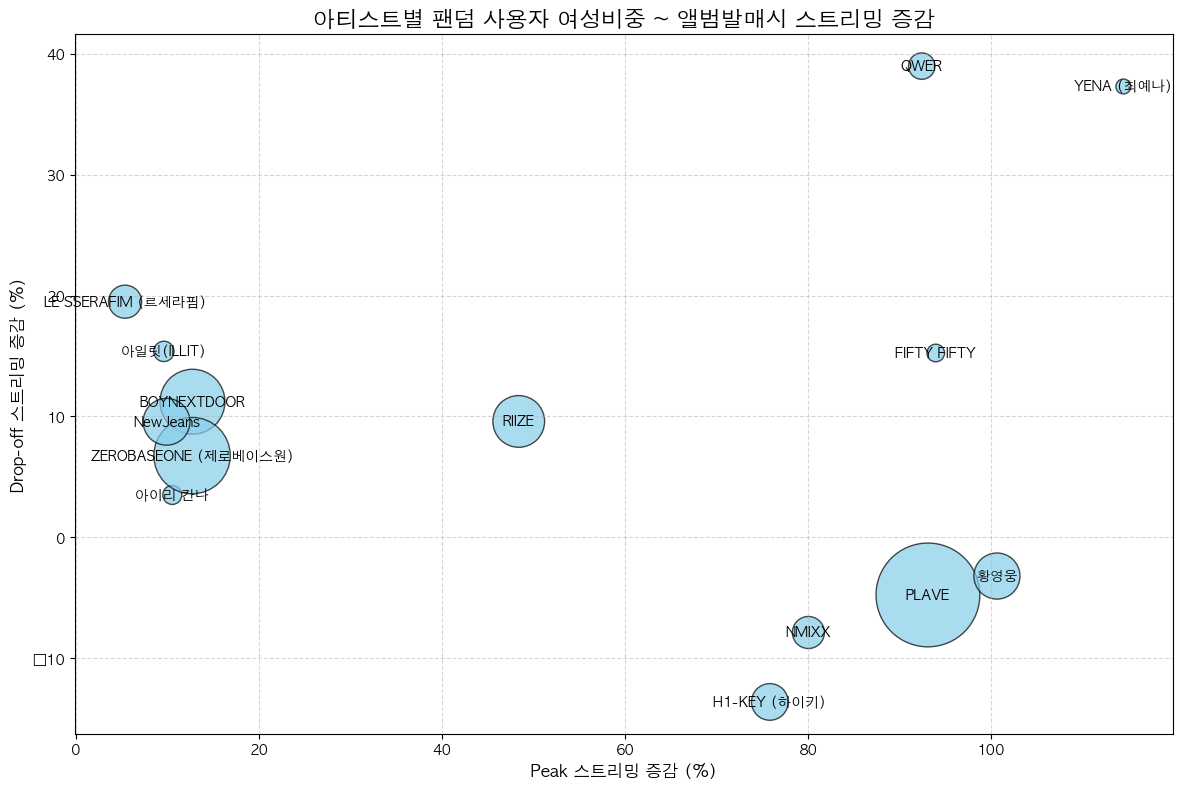

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Scatter plot 생성
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    merged_df['peak_st_incre_ratio'], 
    merged_df['drop_off_st_incre_ratio'],     
    s=merged_df['user_cnt'] / 10,  # 팬덤 사용자 수에 비례한 점 크기
    alpha=0.7, 
    c='skyblue', 
    edgecolor='black'
)

# 각 점에 아티스트 이름 추가
for i, row in merged_df.iterrows():
    plt.text(
        row['peak_st_incre_ratio'], 
        row['drop_off_st_incre_ratio'],         
        row['artist_name'], 
        fontsize=10, 
        ha='center', 
        va='center'
    )

# 그래프 꾸미기
plt.title('아티스트별 팬덤 사용자 여성비중 ~ 앨범발매시 스트리밍 증감', fontsize=16)
plt.xlabel('Peak 스트리밍 증감 (%)', fontsize=12)
plt.ylabel('Drop-off 스트리밍 증감 (%)', fontsize=12)
plt.grid(alpha=0.5, linestyle='--')
plt.tight_layout()

# 그래프 출력
plt.show()

### 20년도 이후 아티스트(팬덤 사용자 500명 이상) 32명 기준으로 k-means 군집화

In [ ]:
# 앨범 발매 전후로 스트리밍 사용량 증감 확인 >  if 스트리밍 사용자 및 사용량 증감이 크다면 이벤트 참여도도 증가할 것
fandom_artist_cluster_query = '''
with artist_df as(    
     select artist_id
         , artist_name
         , fandom_user_cnt
         , male_user_cnt
         , female_user_cnt
         , female_user_ratio
         , age_2030_user_cnt
         , age_2030_user_ratio
         , album_id
         , album_name_web_list as album_name
         , issue_date
         , date(date_parse(issue_date,'%Y%m%d')) as peak_st_strt_date
         , date(date_parse(issue_date,'%Y%m%d') + interval '6' day) as peak_st_end_date
         , date(date_parse(issue_date,'%Y%m%d') - interval '7' day) as pre_st_strt_date
         , date(date_parse(issue_date,'%Y%m%d') - interval '1' day) as pre_st_end_date
         , date(date_parse(issue_date,'%Y%m%d') + interval '7' day) as drop_off_st_strt_date 
         , date(date_parse(issue_date,'%Y%m%d') + interval '14' day) as drop_off_st_end_date 
    from(     
    select B.artist_id
         , C.artist_name_web_list as artist_name
         , A.album_id
         , A.album_name_web_list
         , A.issue_date
         , B.fandom_user_cnt
         , B.male_user_cnt
         , B.female_user_cnt
         , B.female_user_ratio
         , B.age_2030_user_cnt
         , B.age_2030_user_ratio
         , rank() over(partition by A.rep_artist_id_basket order by A.issue_date desc) as rnk
    from hadoop_kent.melon_ods_meta_production.pb_album_dtl_tb_ro A
    join (
        select t1.artist_id
             , t1.fandom_user_cnt
             , t1.male_user_cnt
             , t1.female_user_cnt
             , cast(t1.female_user_cnt as double)/t1.fandom_user_cnt*100 as female_user_ratio
             , t1.age_2030_user_cnt
             , cast(t1.age_2030_user_cnt as double)/t1.fandom_user_cnt*100 as age_2030_user_ratio
        from(
            select artist_id
                 , count(distinct A.member_key) as fandom_user_cnt
                 , count(distinct if(MEMBER_GNDR = 1,A.member_key)) as male_user_cnt
                 , count(distinct if(MEMBER_GNDR = 2,A.member_key)) as female_user_cnt
                 , count(distinct if(AGE_ENT_PRT_CD in (3,4,5,6),A.member_key)) as age_2030_user_cnt
            from HADOOP_KENT.MELON_MA_PROD_PRODUCTION.A_USER_ARTIST_FANDOM_TRGT_DAY A
            left join(
                select MEMBER_KEY
                     , MEMBER_GNDR
                     , AGE_ENT_PRT_CD
                from HADOOP_KENT.MELON_MA_TMK_PRODUCTION.A_USER_PROFILE_DAY
                where log_date = '20250511'
                GROUP BY 1,2,3
            ) B on A.member_key = B.member_key
            where log_date = '20250511'
            AND (CONTAINS(FANDOM_TYPE,'A')=true OR CONTAINS(FANDOM_TYPE,'B')=true OR CONTAINS(FANDOM_TYPE,'C')=true)
            group by 1
            having(count(distinct A.member_key) > 500)
        ) t1    
        left join hadoop_kent.melon_ods_meta_production.pb_artist_dtl_tb_ro t2 on t1.artist_id = t2.artist_id
        where (substr(t2.debut_day,1,4) > '2019' or t1.artist_id in (3478478,3466604))
    ) B on A.rep_artist_id_basket = cast(B.artist_id as varchar)
    left join hadoop_kent.melon_ods_meta_production.pb_artist_dtl_tb_ro C on A.rep_artist_id_basket = cast(C.artist_id as varchar)
    where substr(issue_date,1,8) < '20250501'
    --and A.rep_artist_id_basket in ('3207401','3466604','3458776','3478478','3114174','3180539','3064111','3092950','3070786','3610529','3743525','3457231','3156910','2399724')
    and A.album_type_cd in ('AE0006','AE0007', 'AE0009') /* 미니,정규앨범 기준 */
    --and A.album_type_cd in ('AE0004','AE0007','AE0006','AE0009','AE0010','AE0012') /* 라이브,싱글,EP,정규,OST,베스트 앨범유형 기준 */
    )
    where rnk = 1
), date_df as(
    select melon_short_date_format(dt) as log_date
    from hadoop_kent.melon_ma_stat_production.d_base_dt A
    join artist_df B on A.dt between B.pre_st_strt_date and B.drop_off_st_end_date
    group by 1
)

select f1.artist_id
     , f1.artist_name
     , f1.fandom_user_cnt
     , f1.male_user_cnt
     , f1.female_user_cnt
     , f1.female_user_ratio
     , f1.age_2030_user_cnt
     , f1.age_2030_user_ratio
     , f1.album_name
     , f1.issue_date
     , f1.pre_st_cnt
     , f2.peak_st_cnt
     , f3.drop_off_st_cnt     
     , cast(f2.peak_st_cnt as double)/cast(f1.pre_st_cnt as double) as peak_st_incre
     , cast(f2.peak_st_cnt - f1.pre_st_cnt as double)/cast(f1.pre_st_cnt as double)*100 as peak_st_incre_ratio
     , cast(f3.drop_off_st_cnt as double)/cast(f2.peak_st_cnt as double) as drop_off_st_incre
     , cast(f3.drop_off_st_cnt - f2.peak_st_cnt as double)/cast(f2.peak_st_cnt as double)*100 as drop_off_st_incre_ratio
     , f1.pre_st_lv
     , f2.peak_st_lv
     , f3.drop_off_st_lv
     , cast(f2.peak_st_lv as double)/cast(f1.pre_st_lv as double) as peak_st_lv_incre
     , cast(f2.peak_st_lv - f1.pre_st_lv as double)/cast(f1.pre_st_lv as double)*100 as peak_st_lv_incre_ratio
     , cast(f3.drop_off_st_lv as double)/cast(f2.peak_st_lv as double) as drop_off_st_lv_incre
     , cast(f3.drop_off_st_lv - f2.peak_st_lv as double)/cast(f2.peak_st_lv as double)*100 as drop_off_st_lv_incre_ratio
from(
    select t2.artist_id
         , t2.artist_name
         , t2.album_name
         , t2.issue_date
         , t2.fandom_user_cnt
         , t2.male_user_cnt
         , t2.female_user_cnt
         , t2.female_user_ratio
         , t2.age_2030_user_cnt
         , t2.age_2030_user_ratio
         , sum(st_cnt) as pre_st_cnt
         , count(distinct t1.member_key) as pre_st_lv
    from(
    select artist_id
         , date(buy_date) as dt
         , member_key
         , count(1) as st_cnt
    from hadoop_kent.melon_ma_conts_production.o_Play_log_st_day
    where log_date between '20240322' and '20250515' 
    and log_date in (select log_date from date_df)
    and artist_id in (3207401,3466604,3055146,3458776,3478478,2899555,3114174,3180539,2763924,2863902,3064111,3092950,672853,2736779,3070786,2899079,3610529,2138620,2763943,2899290,2880278,3743525,2645970,3457231,3156910,2399724,780918,3192307,2758756,672855,3089953,2190430)
    group by 1,2,3
    ) t1
    join artist_df t2 on t1.artist_id = t2.artist_id and t1.dt between t2.pre_st_strt_date and t2.pre_st_end_date
    group by 1,2,3,4,5,6,7,8,9,10
) f1
left join(
    select t2.artist_id
         , sum(st_cnt) as peak_st_cnt
         , count(distinct t1.member_key) as peak_st_lv
    from(
    select artist_id
         , date(buy_date) as dt
         , member_key
         , count(1) as st_cnt
    from hadoop_kent.melon_ma_conts_production.o_Play_log_st_day
    where log_date between '20240322' and '20250515'
    and log_date in (select log_date from date_df)
    and artist_id in (3207401,3466604,3055146,3458776,3478478,2899555,3114174,3180539,2763924,2863902,3064111,3092950,672853,2736779,3070786,2899079,3610529,2138620,2763943,2899290,2880278,3743525,2645970,3457231,3156910,2399724,780918,3192307,2758756,672855,3089953,2190430)
    group by 1,2,3
    ) t1
    join artist_df t2 on t1.artist_id = t2.artist_id and t1.dt between t2.peak_st_strt_date and t2.peak_st_end_date
    group by 1
) f2 on f1.artist_id = f2.artist_id
left join(
    select t2.artist_id
         , sum(st_cnt) as drop_off_st_cnt
         , count(distinct t1.member_key) as drop_off_st_lv
    from(
    select artist_id
         , date(buy_date) as dt
         , member_key
         , count(1) as st_cnt
    from hadoop_kent.melon_ma_conts_production.o_Play_log_st_day
    where log_date between '20240322' and '20250515'
    and log_date in (select log_date from date_df)
    and artist_id in (3207401,3466604,3055146,3458776,3478478,2899555,3114174,3180539,2763924,2863902,3064111,3092950,672853,2736779,3070786,2899079,3610529,2138620,2763943,2899290,2880278,3743525,2645970,3457231,3156910,2399724,780918,3192307,2758756,672855,3089953,2190430)
    group by 1,2,3
    ) t1
    join artist_df t2 on t1.artist_id = t2.artist_id and t1.dt between t2.drop_off_st_strt_date and t2.drop_off_st_end_date
    group by 1
) f3 on f1.artist_id = f3.artist_id
'''

cur.execute(fandom_artist_cluster_query)

results = cur.fetchall()
colnames = [part[0] for part in cur.description]

fandom_artist_cluster_df = pd.DataFrame(results, columns=colnames)

cur.cancel()
conn.close()
fandom_artist_cluster_df

,artist_id,artist_name,fandom_user_cnt,male_user_cnt,female_user_cnt,female_user_ratio,age_2030_user_cnt,age_2030_user_ratio,album_name,issue_date,...,peak_st_incre_ratio,drop_off_st_incre,drop_off_st_incre_ratio,pre_st_lv,peak_st_lv,drop_off_st_lv,peak_st_lv_incre,peak_st_lv_incre_ratio,drop_off_st_lv_incre,drop_off_st_lv_incre_ratio
0,3092950,LE SSERAFIM (르세라핌),6157,2935,2745,44.583401,3160,51.323697,Come Over (Remixes),20250331,...,5.374843,1.194878,19.487779,617816,670052,753953,1.084549,8.454945,1.125216,12.521565
1,2763924,이찬원,9653,1246,7901,81.850202,961,9.955454,찬가(燦歌),20250317,...,25.941056,0.947151,-5.284882,67037,72592,71483,1.082865,8.286469,0.984723,-1.527717
2,3156910,FIFTY FIFTY,1656,939,670,40.458937,461,27.838164,Day & Night,20250429,...,93.947495,1.152433,15.243316,163263,216509,237377,1.326136,32.613636,1.096384,9.638398
3,2645970,최유리,2141,688,1354,63.241476,1435,67.024755,외로움이라는 건,20250304,...,23.724528,1.091578,9.157829,331264,376221,393786,1.135714,13.571351,1.046688,4.668798
4,2880278,TREASURE (트레저),2616,547,1967,75.191131,1263,48.279817,SPECIAL MINI ALBUM [PLEASURE],20250307,...,96.984043,1.095320,9.531952,51578,71106,73492,1.378611,37.861104,1.033556,3.355554
5,3478478,RIIZE,14649,1080,12801,87.384804,7235,49.389037,Hug (포옹),20250108,...,48.385232,1.095802,9.580216,455392,543229,578575,1.192882,19.288218,1.065066,6.506648
6,2899079,엔하이픈 (ENHYPEN),5492,696,4546,82.774945,2218,40.386016,Loose,20250404,...,14.190454,1.236539,23.653890,110204,126995,133534,1.152363,15.236289,1.051490,5.149022
7,3192307,8TURN (에잇턴),889,55,828,93.138358,520,58.492688,LEGGO,20250304,...,111.496045,0.963025,-3.697461,3575,7938,6822,2.220420,122.041958,0.859410,-14.058957
8,3458776,BOYNEXTDOOR,22435,2023,19840,88.433252,6655,29.663472,이렇게 좋아해 본 적이 없어요 (소녀의 세계 X BOYNEXTDOOR),20250314,...,12.741454,1.112095,11.209472,661583,713343,778477,1.078237,7.823659,1.091308,9.130811
9,2190430,TOIL,656,316,316,48.170732,427,65.091463,TOTO,20240329,...,143.912861,0.812868,-18.713177,233767,288669,289481,1.234858,23.485779,1.002813,0.281291


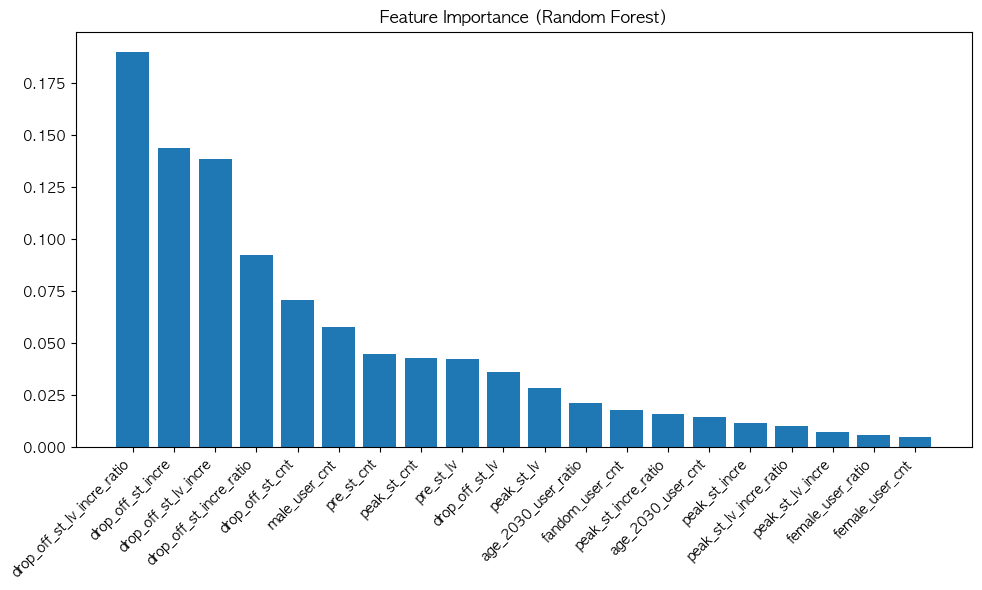

상위 중요 feature: ['drop_off_st_lv_incre_ratio', 'drop_off_st_incre', 'drop_off_st_lv_incre', 'drop_off_st_incre_ratio', 'drop_off_st_cnt', 'male_user_cnt', 'pre_st_cnt', 'peak_st_cnt']


In [52]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 클러스터링 결과를 target(라벨)로 사용
features = [
    'fandom_user_cnt', 'male_user_cnt', 'female_user_cnt', 'female_user_ratio',
    'age_2030_user_cnt', 'age_2030_user_ratio', 'pre_st_cnt', 'peak_st_cnt', 'drop_off_st_cnt',
    'peak_st_incre', 'peak_st_incre_ratio', 'drop_off_st_incre', 'drop_off_st_incre_ratio',
    'pre_st_lv', 'peak_st_lv', 'drop_off_st_lv',
    'peak_st_lv_incre', 'peak_st_lv_incre_ratio', 'drop_off_st_lv_incre', 'drop_off_st_lv_incre_ratio'
]
X = fandom_artist_cluster_df[features].dropna()
y = fandom_artist_cluster_df.loc[X.index, 'cluster']

# 표준화(선택)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 랜덤포레스트 분류기 학습
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

# 중요도 추출
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# 시각화
plt.figure(figsize=(10, 6))
plt.title("Feature Importance (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 중요도 상위 n개 feature 확인
top_n = 8
top_features = [features[i] for i in indices[:top_n]]
print("상위 중요 feature:", top_features)

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 사용할 feature 선택
features = [
    'fandom_user_cnt', 'male_user_cnt', 'female_user_cnt', 'female_user_ratio',
    'age_2030_user_cnt', 'age_2030_user_ratio', 'pre_st_cnt', 'peak_st_cnt', 'drop_off_st_cnt',
    'peak_st_incre', 'peak_st_incre_ratio', 'drop_off_st_incre', 'drop_off_st_incre_ratio',
    'pre_st_lv', 'peak_st_lv', 'drop_off_st_lv',
    'peak_st_lv_incre', 'peak_st_lv_incre_ratio', 'drop_off_st_lv_incre', 'drop_off_st_lv_incre_ratio'
]
X = fandom_artist_cluster_df[features].dropna()

# 1) PCA로 차원 축소 (설명분산 95%까지 유지)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f'PCA 축소 후 차원 수: {X_pca.shape[1]}')



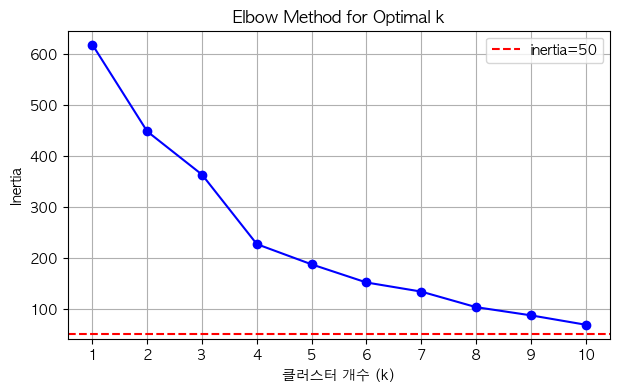

In [41]:
# 2) Elbow method로 적정 클러스터 수 확인 (inertia < 50 기준)
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(K, inertia, 'o-', color='blue')
plt.xlabel('클러스터 개수 (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(K)
plt.grid(True)
plt.axhline(50, color='red', linestyle='--', label='inertia=50')
plt.legend()
plt.show()

/var/folders/qw/6lks7c5d14scf7qtctm8m6jh0000gn/T/ipykernel_50584/2846234658.py:18: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


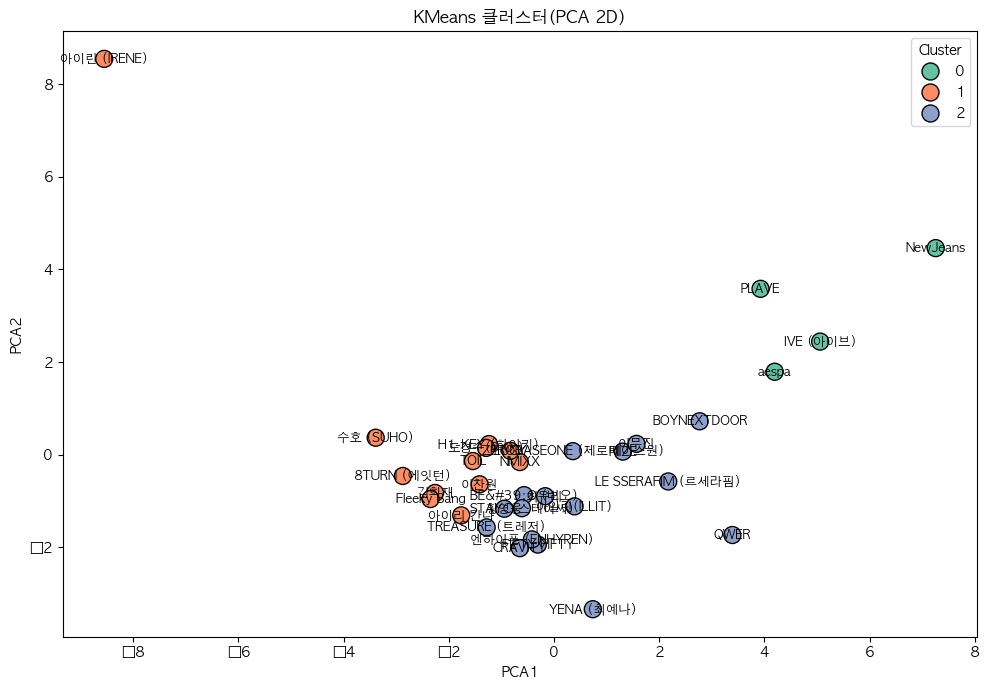

In [42]:
# 3) KMeans 클러스터링
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)
fandom_artist_cluster_df['cluster'] = clusters

# 4) 시각화 (PCA 2D scatter plot)
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=clusters, palette='Set2', s=150, edgecolor='black'
)
for i, row in fandom_artist_cluster_df.iterrows():
    plt.text(X_pca[i, 0], X_pca[i, 1], row['artist_name'], fontsize=9, ha='center', va='center')
plt.title('KMeans 클러스터(PCA 2D)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster', loc='best')
plt.tight_layout()
plt.show()

/var/folders/qw/6lks7c5d14scf7qtctm8m6jh0000gn/T/ipykernel_50584/1000743306.py:31: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


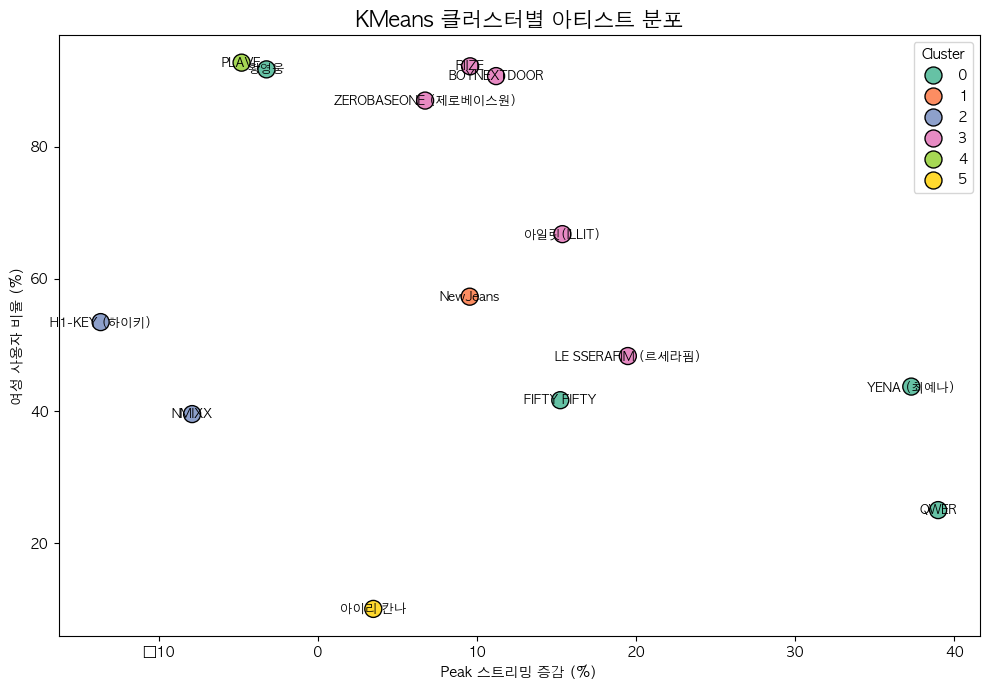

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# 2차원 feature space 예시: peak_st_incre_ratio vs female_user_ratio
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=merged_df,
    x='drop_off_st_incre_ratio',
    y='female_user_ratio',
    hue='cluster',
    palette='Set2',
    s=150,
    edgecolor='black'
)

# 각 점에 아티스트 이름 표시
for i, row in merged_df.iterrows():
    plt.text(
        row['drop_off_st_incre_ratio'],
        row['female_user_ratio'],
        row['artist_name'],
        fontsize=9,
        ha='center',
        va='center'
    )

plt.title('KMeans 클러스터별 아티스트 분포', fontsize=15)
plt.xlabel('Peak 스트리밍 증감 (%)')
plt.ylabel('여성 사용자 비율 (%)')
plt.legend(title='Cluster', loc='best')
plt.tight_layout()
plt.show()